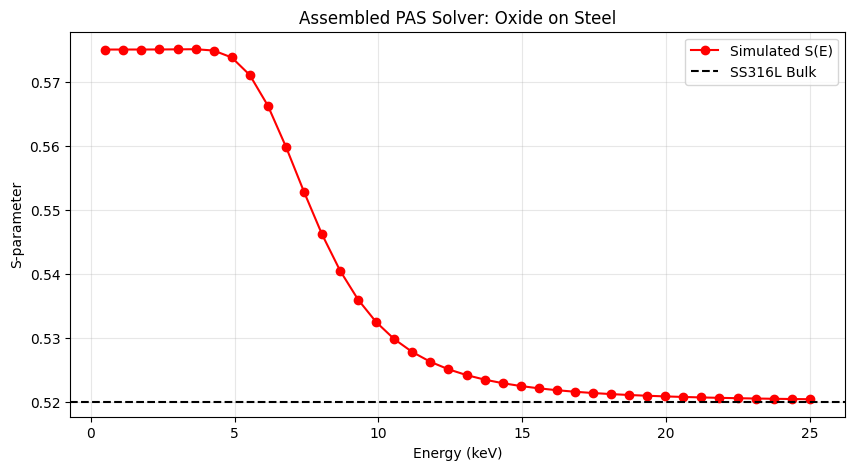

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.optimize import curve_fit

# --- 1. CORE PHYSICS: IMPLANTATION & DIFFUSION ---

def calculate_profiles(z_grid, energy_kev, layers):
    """
    Calculates the Implantation P(z) and Diffusion-corrected Annihilation c(z).
    """
    dz = z_grid[1] - z_grid[0]
    n_pts = len(z_grid)
    
    # Map physical properties to the z-grid
    densities = np.zeros_like(z_grid)
    mass_depth = np.zeros_like(z_grid)
    L_grid = np.zeros_like(z_grid)
    
    curr_z, acc_mass = 0, 0
    for l in layers:
        mask = (z_grid >= curr_z) & (z_grid <= curr_z + l['thickness'])
        densities[mask] = l['density']
        L_grid[mask] = l['L_diff']
        # Density-weighted path (mass depth)
        mass_depth[mask] = acc_mass + (z_grid[mask] - curr_z) * l['density'] * 0.1
        acc_mass += l['thickness'] * l['density'] * 0.1
        curr_z += l['thickness']

    # Implantation Profile (Makhov)
    A, n, m = 4.0, 1.6, 2.0
    xi_0 = (A * energy_kev**n) / 0.886
    p_xi = (m * mass_depth**(m-1) / xi_0**m) * np.exp(-(mass_depth/xi_0)**m)
    p_z = p_xi * densities
    p_z /= np.trapezoid(p_z, z_grid)

    # Solve Diffusion Equation: L^2 * d2c/dz2 - c = -P
    main_diag = -2 * (L_grid**2 / dz**2) - 1
    off_diag = (L_grid[1:]**2 / dz**2)
    matrix = diags([off_diag, main_diag, off_diag], [-1, 0, 1], shape=(n_pts, n_pts)).tocsr()
    
    c_z = spsolve(matrix, -p_z)
    c_z /= np.trapezoid(c_z, z_grid)
    
    return p_z, c_z

# --- 2. THE SOLVER: S(E) SIMULATION & FITTING ---

def simulate_S_curve(energies, layers, z_max=2000):
    """
    Simulates the measured S-parameter vs Energy curve.
    """
    z_grid = np.linspace(0, z_max, 1000)
    
    # Map S-bulk values to the grid
    s_grid = np.zeros_like(z_grid)
    curr_z = 0
    for l in layers:
        mask = (z_grid >= curr_z) & (z_grid <= curr_z + l['thickness'])
        s_grid[mask] = l['S_bulk']
        curr_z += l['thickness']

    simulated_S = []
    for E in energies:
        _, c_z = calculate_profiles(z_grid, E, layers)
        # Measured S is the weighted average of the annihilation distribution
        s_val = np.trapezoid(c_z * s_grid, z_grid)
        simulated_S.append(s_val)
        
    return np.array(simulated_S)

# --- 3. EXECUTION EXAMPLE: Fe2O3 on SS316L ---

# Define experimental context
exp_energies = np.linspace(0.5, 25, 40)
my_layers = [
    {'name': 'Fe2O3', 'thickness': 155, 'density': 5.24, 'L_diff': 30, 'S_bulk': 0.575},
    {'name': 'SS316L', 'thickness': 2000, 'density': 8.00, 'L_diff': 150, 'S_bulk': 0.520}
]

# Run Simulation
s_curve = simulate_S_curve(exp_energies, my_layers)

# Plotting Results
plt.figure(figsize=(10, 5))
plt.plot(exp_energies, s_curve, 'r-o', label='Simulated S(E)')
plt.axhline(0.520, color='k', linestyle='--', label='SS316L Bulk')
plt.xlabel('Energy (keV)')
plt.ylabel('S-parameter')
plt.title('Assembled PAS Solver: Oxide on Steel')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

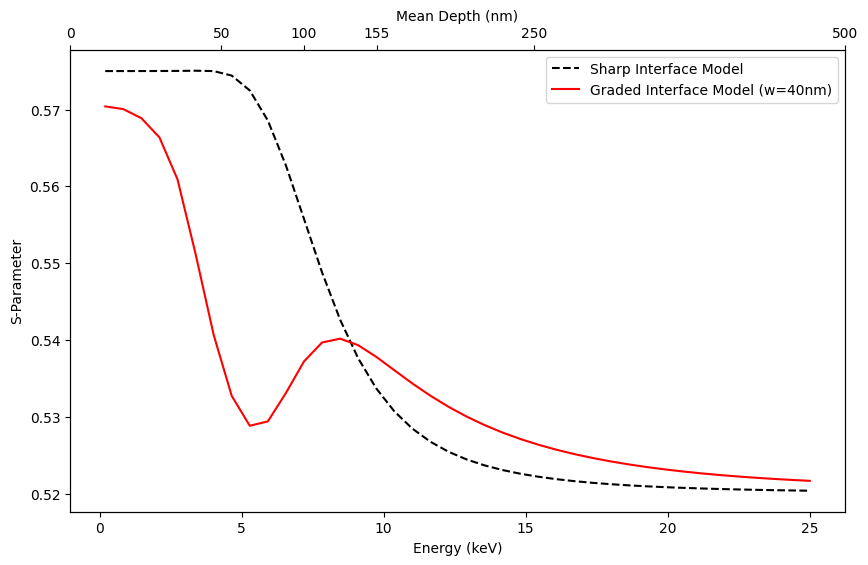

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.optimize import curve_fit

# --- 1. CORE PHYSICS FUNCTIONS ---

def calculate_annihilation_profile(z_grid, energy_kev, layers, model_type='sharp', transition_w=10.0):
    """
    Paradigm: Diffusion-Limited Model
    Calculates the final distribution of positrons at the moment of annihilation.
    """
    dz = z_grid[1] - z_grid[0]
    n_pts = len(z_grid)
    
    # Map physical properties (Density, Diffusion Length) to the grid
    densities = np.zeros_like(z_grid)
    mass_depth = np.zeros_like(z_grid)
    L_grid = np.zeros_like(z_grid)
    
    curr_z, acc_mass = 0, 0
    d_ox = layers[0]['thickness']
    
    for i, z_val in enumerate(z_grid):
        if model_type == 'sharp':
            rho = layers[0]['density'] if z_val <= d_ox else layers[1]['density']
            L = layers[0]['L_diff'] if z_val <= d_ox else layers[1]['L_diff']
        else: # Graded Model (Sigmoid transition)
            rho = layers[0]['density'] + (layers[1]['density'] - layers[0]['density']) / (1 + np.exp(-(z_val - d_ox) / (transition_w/4)))
            L = layers[0]['L_diff'] + (layers[1]['L_diff'] - layers[0]['L_diff']) / (1 + np.exp(-(z_val - d_ox) / (transition_w/4)))
        
        densities[i] = rho
        L_grid[i] = L
        acc_mass += rho * dz * 0.1 # 0.1 for unit normalization (g/cm3 * nm)
        mass_depth[i] = acc_mass

    # Implantation Profile (Makhov)
    A, n, m = 4.0, 1.6, 2.0
    xi_0 = (A * energy_kev**n) / 0.886
    p_xi = (m * mass_depth**(m-1) / xi_0**m) * np.exp(-(mass_depth/xi_0)**m)
    p_z = p_xi * densities
    p_z /= np.trapezoid(p_z, z_grid)

    # Solve Steady-State Diffusion: L^2 * d2c/dz2 - c + P = 0
    main_diag = -2 * (L_grid**2 / dz**2) - 1
    off_diag = (L_grid[1:]**2 / dz**2)
    matrix = diags([off_diag, main_diag, off_diag], [-1, 0, 1], shape=(n_pts, n_pts)).tocsr()
    
    c_z = spsolve(matrix, -p_z)
    return c_z / np.trapezoid(c_z, z_grid)

# --- 2. EXPERIMENTAL SIMULATION & S-PARAMETER PARADIGMS ---

def simulate_s_curve(energies, layers, model_type='sharp', transition_w=10.0):
    """
    Simulates the Measured S-parameter curve across a range of energies.
    """
    z_grid = np.linspace(0, 2000, 1000)
    s_sim = []
    
    # S(z) Map
    d_ox = layers[0]['thickness']
    s_z = np.zeros_like(z_grid)
    for i, z_val in enumerate(z_grid):
        if model_type == 'sharp':
            s_z[i] = layers[0]['S_bulk'] if z_val <= d_ox else layers[1]['S_bulk']
        else: # Graded S-Parameter
            s_z[i] = layers[1]['S_bulk'] + (layers[0]['S_bulk'] - layers[1]['S_bulk']) / (1 + np.exp((z_val - d_ox) / (transition_w/4)))

    for E in energies:
        c_z = calculate_annihilation_profile(z_grid, E, layers, model_type, transition_w)
        s_val = np.trapezoid(c_z * s_z, z_grid)
        s_sim.append(s_val)
        
    return np.array(s_sim)

# --- 3. DUAL-AXIS MAPPING ---

def energy_to_depth(E, layers):
    """Maps Energy to Mean Implantation Depth (z_bar) for different densities."""
    A, n = 4.0, 1.6
    mass_capacity = A * (E**n)
    oxide_limit = layers[0]['density'] * layers[0]['thickness'] * 0.1
    if mass_capacity <= oxide_limit:
        return mass_capacity / (layers[0]['density'] * 0.1)
    else:
        return layers[0]['thickness'] + (mass_capacity - oxide_limit) / (layers[1]['density'] * 0.1)

# --- 4. EXECUTION AND FINDINGS ---

my_layers = [
    {'name': 'Fe2O3', 'thickness': 155, 'density': 5.24, 'L_diff': 30, 'S_bulk': 0.575},
    {'name': 'SS316L', 'thickness': 2000, 'density': 8.00, 'L_diff': 150, 'S_bulk': 0.520}
]

energies = np.linspace(0.2, 25, 40)
s_sharp = simulate_s_curve(energies, my_layers, model_type='sharp')
s_graded = simulate_s_curve(energies, my_layers, model_type='graded', transition_w=40.0)

# Plotting with Dual Axis
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(energies, s_sharp, 'k--', label='Sharp Interface Model')
ax1.plot(energies, s_graded, 'r-', label='Graded Interface Model (w=40nm)')
ax1.set_xlabel('Energy (keV)')
ax1.set_ylabel('S-Parameter')
ax1.legend()

# Top Axis: Depth
ax2 = ax1.twiny()
depth_ticks = [0, 50, 100, 155, 250, 500]
energy_ticks = [((d * 0.524 if d <= 155 else 155*0.524 + (d-155)*0.8)/4)**(1/1.6) for d in depth_ticks]
ax2.set_xticks(energy_ticks)
ax2.set_xticklabels([f"{d}" for d in depth_ticks])
ax2.set_xlabel('Mean Depth (nm)')
plt.show()